In [8]:
from import_helm_lite import read_helm_list
from calculate_statistics import calculate_stats, num_words, rank_questions
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = read_helm_list(version='v1.11.0/', 
                    instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=meta_llama-3.3-70b-instruct-turbo/')
df2 = read_helm_list(version='v1.11.0/', 
                    instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=upstage_solar-pro-241126/')
df3 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=anthropic_claude-3-5-sonnet-20241022/')
df4 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=google_gemini-1.5-flash-002/')
df5 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=google_gemini-1.5-pro-002/')
df6 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=openai_gpt-4o-2024-08-06/')

In [3]:
dfs = [df, df2, df3, df4, df5, df6]

In [4]:
ranked_questions = rank_questions(dfs, metric_name='stats.exact_match', desired_stat_name='num_words')

In [16]:
ranked_questions.head()

,instance_id,input.text,predicted_text_0,stats.exact_match_0,num_words_0,predicted_text_1,stats.exact_match_1,num_words_1,predicted_text_2,stats.exact_match_2,...,predicted_text_3,stats.exact_match_3,num_words_3,predicted_text_4,stats.exact_match_4,num_words_4,predicted_text_5,stats.exact_match_5,num_words_5,std
0,id10,Statement 1 | The symmetric group S_3 is cycli...,D,1.0,22,D,1.0,22,D,1.0,...,D,1.0,22,D,1.0,22,D,1.0,22,0.0
35,id29,The polynomial x^3 + 2x^2 + 2x + 1 can be fact...,B,0.0,21,D,0.0,21,D,0.0,...,B,0.0,21,B,0.0,21,B,0.0,21,0.0
40,id34,The set of all real numbers under the usual mu...,D,1.0,17,D,1.0,17,D,1.0,...,D,1.0,17,D,1.0,17,D,1.0,17,0.0
41,id35,Statement 1| Every group of order p^2 where p ...,A,1.0,47,A,1.0,47,A,1.0,...,A,1.0,47,A,1.0,47,A,1.0,47,0.0
45,id39,The set of all nth roots of unity under multip...,D,1.0,16,D,1.0,16,D,1.0,...,D,1.0,16,D,1.0,16,D,1.0,16,0.0


Below is a dumb example of a plot because for MMLU all the model responses have 1 letter, so all the word counts (input text + output text) are the exact same

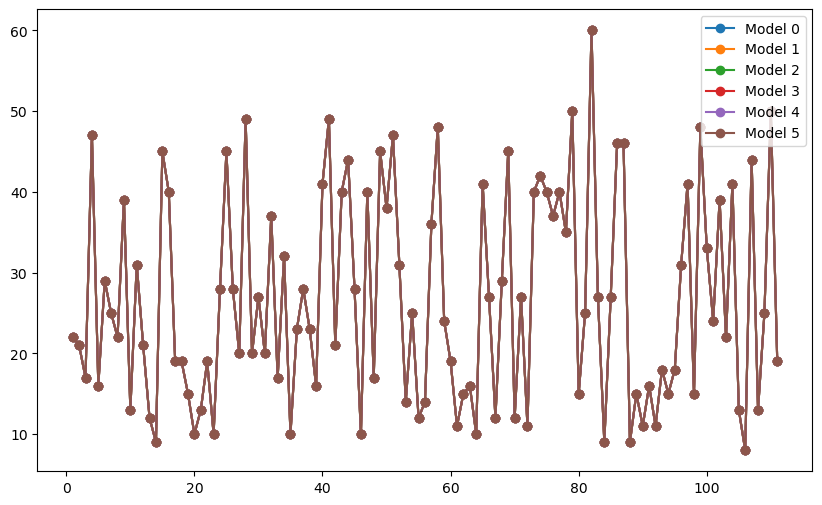

In [15]:
# Create the plot:
plt.figure(figsize=(10, 6))
x_values = range(1, ranked_questions.shape[0] + 1)  # ranking positions

# Plot word counts for each model.
for i in range(len(dfs)):
    plt.plot(x_values, ranked_questions[f'num_words_{i}'], marker='o', label=f'Model {i}')
    
plt.legend()

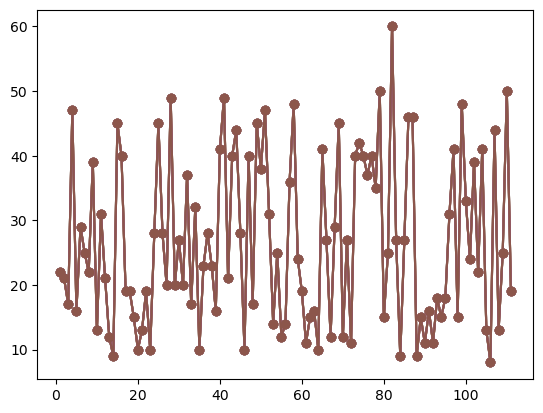